In [1]:
# Imports, check version 

import h5py
import numpy as np
from scipy import stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import psutil
import resource
from functools import partial
from collections import Counter
import itertools
import multiprocessing as mp
import os
import re
import sys
print(sys.version)

from sys import path
path.append('/mnt/smb/locker/issa-locker/users/Dan/code')
from data_analysis_tools_mkTurk.utils_meta import get_recording_path
from data_analysis_tools_mkTurk.general import df_2_psth_mat
from data_analysis_tools_mkTurk.IO import ch_dicts_2_h5, h5_2_trial_df, h5_2_df
from data_analysis_tools_mkTurk.npix import chs_meta_2_site_coords, h5_2_ch_meta
from mkutils_ddk.IO import sessions2spikes, find_h5_path

3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]


In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
# Test: load an h5 file
pathname = '/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240403_R_H01_P52/20240403.h5'
f = h5py.File(pathname)
list(f.keys())

['data',
 'imro_table',
 'stim_indices',
 'trial_params',
 'trial_params_short',
 'zero_coordinates']

In [4]:
# Define memory checking functions
def check_mem():
    # Current process memory usage
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    print(f"Current process memory: {memory_mb:.2f} MB")
    
    # System memory info
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / 1024**3:.2f} GB")
    print(f"Available memory: {memory.available / 1024**3:.2f} GB")
    print(f"Memory usage: {memory.percent}%")

def check_rss():
    process = psutil.Process()
    rss_current = process.memory_info().rss / 1024**3
    print(f"Current RSS usage: {rss_current:.2f} GB")
    
    # Check the limit
    soft, hard = resource.getrlimit(resource.RLIMIT_RSS)
    print(f"RSS limit: {soft/1024**3:.2f} GB (soft), {hard/1024**3:.2f} GB (hard)")

def get_size(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum([get_size(v) for v in obj.values()])
        size += sum([get_size(k) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i) for i in obj])
    
    return size

def check_mem_max():
    # Check various process limits
    limits_to_check = [
        (resource.RLIMIT_AS, "Virtual memory"),
        (resource.RLIMIT_DATA, "Data segment"),
        (resource.RLIMIT_RSS, "Resident set size"),
    ]
    
    for limit_type, name in limits_to_check:
        try:
            soft, hard = resource.getrlimit(limit_type)
            if soft != resource.RLIM_INFINITY:
                print(f"{name}: {soft / 1e9:.1f}GB (soft), {hard / 1e9:.1f}GB (hard)")
            else:
                print(f"{name}: Unlimited")
        except (ValueError, OSError):
            print(f"{name}: Not available on this system")

In [5]:
# Define functions for dates --> h5_paths and dataframe 

def h5_paths(monkeys, dates):
    # Note dates is a series
    paths = []
    recording_prefix = '/mnt/smb/locker/issa-locker/users/Dan/ephys'
    for monkey in monkeys:
        monkey_pens = os.listdir(f'{recording_prefix}/{monkey}')
        date_2_pen = {date: [pen for pen in monkey_pens if date in pen] for date in dates[monkey]}
        paths += [f'{recording_prefix}/{monkey}/{pen[0]}/{date}.h5' for date,pen in date_2_pen.items()]
    return paths

def sess_2_df(path, scenefiles, time_window):
    
    # Create filter for scenefiles
    trial_params = h5_2_trial_df(path)
    filter = trial_params.scenefile.isin(scenefiles)
    scenefile_trials = trial_params[filter]
    array_filter = np.array(scenefile_trials[['trial_num', 'rsvp_num']])
    
    # Read spike count data from HDF5 for requested trials:
    df = h5_2_df(path, trials=array_filter, time_window=time_window)
    
    # Sort df to match trial_params, rust_trials
    df.sort_index(inplace=True)
    
    return df

In [109]:
# Create df of monkey/imageset --> dates 

pens_df = pd.DataFrame(columns=['Rust', 'HvM', 'EliasNeptune', 'Objaverse', 'RSVP66'], index=['West', 'Bourgeois'])

# West Rust
west_rust_dates = ['20231129', '20231130', '20240403']
pens_df.loc['West','Rust'] = west_rust_dates

# Bourgeois Rust

pens_list = [
    'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241108_R_H00_P09/all_psth.h5',
    'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241111_R_H00_P10/all_psth.h5',
    'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241122_R_H00_P19/all_psth.h5',
    'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241205_R_H00_P26/all_psth.h5',
    'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241230_R_H00_P39/all_psth.h5']

bour_rust_dates = sorted([path[87:95] for path in pens_list])
pens_df.loc['Bourgeois', 'Rust'] = bour_rust_dates

# West HvM

pens_list = ['axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240912_R_H01_P73/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240913_R_H01_P74/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20240923_R_H01_P76/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20241002_R_H01_P80/all_psth.h5',
'axon.rc.zi.columbia.edu/mnt/smb/locker/issa-locker/users/Dan/ephys/West/West_20241008_R_H02_P38/all_psth.h5']

west_hvm_dates = sorted([path[77:85] for path in pens_list])
pens_df.loc['West', 'HvM'] = west_hvm_dates

# Bourgeois HvM

pens_list = ['/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241206_R_H00_P27/20241206.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241202_R_H00_P23/20241202.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241227_R_H00_P38/20241227.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241126_R_H00_P21/20241126.h5',
 '/Volumes/issa-locker/users/Dan/ephys/Bourgeois/Bourgeois_20241127_R_H00_P22/20241127.h5']

bour_hvm_dates = sorted([path[57:65] for path in pens_list])
pens_df.loc['Bourgeois', 'HvM'] = bour_hvm_dates

# Bourgeois EliasNeptune
pens_df.loc['Bourgeois', 'EliasNeptune'] = sorted(['20241230', '20241122', '20241108',
                                                   '20241205', '20241111'])

# West EliasNeptune 
pens_df.loc['West', 'EliasNeptune'] = sorted(['20231129', '20231130', '20240403'])

# Bourgeois Objaverse (same as rust, but theres more if want, just need to ask dan to fix)
pens_df.loc['Bourgeois', 'Objaverse'] = sorted(['20241108', '20241111', '20241122',
                                                '20241205', '20241230'])

# West Objaverse (again, many more, this is overlap with rust/hvm)
pens_df.loc['West', 'Objaverse'] = sorted(['20231129', '20231130', '20240403',
                                    '20240912', '20240913', '20240923', 
                                    '20241002', '20241008'])

# RSVP66 (note only taking first 5)
pens_df.loc['West', 'RSVP66'] = sorted(['20240808', '20240410', '20240712', '20240412', '20240416', '20240409',
                                 '20240815', '20240418', '20240417', '20240607', '20240606', '20240411',
                                 '20240723', '20240408'])

pens_df.loc['Bourgeois', 'RSVP66'] = sorted(['20250130', '20250117', '20250411', '20250501', '20250131',
                                      '20250116', '20250414', '20250423', '20250430', '20250421',
                                      '20250415', '20250114'])

pens_df

,Rust,HvM,EliasNeptune,Objaverse,RSVP66
West,"[20231129, 20231130, 20240403]","[20240912, 20240913, 20240923, 20241002, 20241...","[20231129, 20231130, 20240403]","[20231129, 20231130, 20240403, 20240912, 20240...","[20240408, 20240409, 20240410, 20240411, 20240..."
Bourgeois,"[20241108, 20241111, 20241122, 20241205, 20241...","[20241126, 20241127, 20241202, 20241206, 20241...","[20241108, 20241111, 20241122, 20241205, 20241...","[20241108, 20241111, 20241122, 20241205, 20241...","[20250114, 20250116, 20250117, 20250130, 20250..."


In [50]:
# Create scenefile dict, prefix dict
imageset_to_scenefiles = {
    'Rust': ['/mkturkfiles/scenebags/West/20231025_Rust_NaturalImages300_300ms.json'],
    'Objaverse': ['/mkturkfiles/scenebags/West/neural_stim_4_0ABCDEFGHIJ.json'],
    'EliasNeptune': ['/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_neptune_dur300ms_lab_updated.json',
       '/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_elias_dur300ms_lab_updated.json'],
    'HvM': ['/mkturkfiles/scenebags/West/hvm10_table_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_elephant_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_dog_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_bear_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_chair_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_car_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_turtle_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_plane_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_apple_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_head_45_20240906.json'],
    'RSVP66': ['/mkturkfiles/scenebags/West/neural_stim_5_1ABC_RSVP66_00.json']
}

# Set prefixes for imagesets (before scenefile names)
imageset_to_prefix = {
    'Rust': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/Saved_Images_West_neural_stim__RustDiCarlo_NaturalImages/Save_Images_West_RustDiCarlo/',
    'EliasNeptune': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/Saved_Images_West_neural_stim_EliasNeptune/Save_Images_West_EliasNeptune/',
    'HvM': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/hvm10/',
    'Objaverse': '/mnt/smb/locker/issa-locker/Data/Bourgeois/Saved_Images/E0/',
    'RSVP66': '/mnt/smb/locker/issa-locker/Data/West/Saved_Images/Saved_Images_West_neural_stim_5_E6/'
}

In [51]:
# Function for finding imageset dates (use if needed)
def find_paths(imageset, monkey):
    test_scenefile = imageset_to_scenefiles[imageset][0]
    h5_paths = []
    imageset_paths = []
    
    for root, dirs, files in os.walk(f'/mnt/smb/locker/issa-locker/users/Dan/ephys/{monkey}'):
        for file in files:
            if file.endswith('.h5'):
                 h5_paths.append(os.path.join(root, file))
    for path in h5_paths:
        try:
            trial_params = h5_2_trial_df(path)
            if test_scenefile in trial_params.scenefile.values:
                imageset_paths.append(path)
        except:
            print(f'{path} didnt work')
    return imageset_paths

In [82]:
# Set analysis parameters
monkeys = ['West', 'Bourgeois']
imageset = 'Objaverse'
start_bin = 0
end_bin = .301
cores = 12
gpu_count = 2

notes = 'TEST'

In [83]:
# Best pens
''' Best pens for each
Bour Rust: 20241122
West Rust: 20231129 ~200 (remaining pens are <5)
Bour HvM: all except 20241227 are ~150
West HvM: 20240912 + 20240913 (remaining pens are <5)
'''

' Best pens for each\nBour Rust: 20241122\nWest Rust: 20231129 ~200 (remaining pens are <5)\nBour HvM: all except 20241227 are ~150\nWest HvM: 20240912 + 20240913 (remaining pens are <5)\n'

In [84]:
# Get dates, paths
dates = pens_df.loc[monkeys, imageset]
paths = h5_paths(monkeys, dates)
scenefiles = imageset_to_scenefiles[imageset]
time_window = [start_bin, end_bin] # in seconds

h5_df_columns = ['monkey', 'date', 'trial_num', 'rsvp_num', 'stim_id', 'stim_idx',
       'scenefile', 'behav_file', 'img_full_path', 'psth_bins', 'source_path',
       'psth']

print(dates.sum())

['20231129', '20231130', '20240403', '20240912', '20240913', '20240923', '20241002', '20241008', '20241108', '20241111', '20241122', '20241205', '20241230']


In [85]:
%%time
# Get combined dataframe for sessions
with mp.Pool(processes=cores) as pool:
    process_func = partial(sess_2_df, scenefiles=scenefiles, time_window=time_window)
    results = pool.map(process_func, paths)

# Combine all results
combined_sess_df = pd.concat(results, ignore_index=True)

combined_sess_df.shape

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...

Fetching trial parameters...Fetching trial parameters...

Fetching trial parameters...

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)
/share/apps/anaconda

... done (0.05278325080871582 sec).


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


inds_df.shape = (597, 2)
... done (0.077789306640625 sec).
inds_df.shape = (600, 2)


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.0969991683959961 sec).... done (0.0944681167602539 sec).

... done (0.10411620140075684 sec).inds_df.shape = (900, 2)inds_df.shape = (900, 2)


... done (0.10632610321044922 sec).
inds_df.shape = (600, 2)inds_df.shape = (600, 2)

Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Fetching trial parameters...
... done (0.04529881477355957 sec).
inds_df.shape = (591, 2)

/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)



Pre-fetching PSTHs from HDF5...
... done (0.04680800437927246 sec).
inds_df.shape = (600, 2)
Pre-fetching PSTHs from HDF5...
... done (0.08676290512084961 sec).
inds_df.shape = (600, 2)
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Fetching trial parameters...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done (0.09334087371826172 sec).
inds_df.shape = (600, 2)
Fetching trial parameters...
Pre-fetching PSTHs from HDF5...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...Pre-fetching PSTHs from HDF5...
... done (0.08822798728942871 sec).
inds_df.shape = (600, 2)

Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
... done (0.10909700393676758 sec).
inds_df.shape = (600, 2)
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.21019907395044962 minutes
Fancy slicing numpy array...
... done.
Duration=0.2100987156232198 minutes
Fancy slicing numpy array...
... done.
Duration=0.0024644970893859864 minutes
... done.
Duration=0.0028556068738301594 minutes
... done.
Duration=0.21984981298446654 minutes
Fancy slicing numpy array...
... done.
Duration=0.001728367805480957 minutes


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done.
Duration=0.23006552855173748 minutes
Fancy slicing numpy array...
Fetching trial parameters...
... done.
Duration=0.003359413146972656 minutes
... done.
Duration=0.23772616783777872 minutes
Fancy slicing numpy array...


/share/apps/anaconda3-2023.07.03/lib/python3.11/site-packages/tables/attributeset.py:291: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done.
Duration=0.24326674143473306 minutes
Fancy slicing numpy array...
... done.
Duration=0.0033316930135091146 minutes
... done (0.4438588619232178 sec).
inds_df.shape = (684, 2)
... done.
Duration=0.0019699613253275554 minutes
... done.
Duration=0.24544780254364013 minutes
Fancy slicing numpy array...
Pre-fetching PSTHs from HDF5...
... done.
Duration=0.24855699141820273 minutes
Fancy slicing numpy array...
... done.
Duration=0.25061614910761515 minutes
Fancy slicing numpy array...
... done.
Duration=0.003399487336476644 minutes
... done.
Duration=0.0017981688181559245 minutes
... done.
Duration=0.25326812664667764 minutes
Fancy slicing numpy array...
... done.
Duration=0.0030194600423177082 minutes
... done.
Duration=0.001806791623433431 minutes
... done.
Duration=0.24772106409072875 minutes
Fancy slicing numpy array...
... done.
Duration=0.004178440570831299 minutes
... done.
Duration=0.33980598449707033 minutes
Fancy slicing numpy array...
... done.
Duration=0.003498001893361

(8472, 12)

In [86]:
# Create + apply mask to remove nans
mask = combined_sess_df.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)
final_df = combined_sess_df[-mask]
print(final_df.shape)

(7027, 12)


In [87]:
# Set prefix
prefix = imageset_to_prefix[imageset]

In [88]:
# Get paths without img_full_path using scenefile + stim_idx (scenefile...idx.png)

start_idx = 28 # based on '/mkturkfiles/scenebags/West/...'
final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]

# Generate img_full_path
def png_path_end_int(path):
    match = re.search(r'(\d+)\.png$', path)
    if match:
        return int(match.group(1))  # Returns "123" as string
    else:
        return None

for scenefile in final_df['spliced_scenefile'].unique():
    sfile_path = prefix + scenefile
    img_list = os.listdir(sfile_path)
    # Note: there is one .json in each scenefile, which is mapped to None in dict
    idx_to_path = {png_path_end_int(img):'/'.join([sfile_path, img]) for img in img_list}
    scene_mask = final_df['spliced_scenefile'] == scenefile
    final_df.loc[scene_mask, 'img_full_path'] = final_df.loc[scene_mask, 'stim_idx'].map(idx_to_path)

print(f'Unique images: {final_df.img_full_path.unique().shape[0]}')

Unique images: 10


/tmp/ipykernel_245053/1809291868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['spliced_scenefile'] = final_df['scenefile'].str.removesuffix('.json').str[start_idx:]
/tmp/ipykernel_245053/1809291868.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[scene_mask, 'img_full_path'] = final_df.loc[scene_mask, 'stim_idx'].map(idx_to_path)


In [89]:
def ch_shr(ch_data, path_list, min_repeats):
    ''' Gets the split-halves reliability for a single channel

    Args:
        ch_data (n by 1 array): ordered channel activity
        path_list: ordered image paths
        min_repeats: minimum repetitions required for an image to be used

    Returns:
        shr: split-halves reliability
        count_arr: matrix of max repetitions x image for the channel
    '''
    # ch_data --> count_arr using path_list
    path_counts = Counter(path_list)
    valid_paths = [path for path, count in path_counts.items() if count >= min_repeats]
    unique_imgs = set(valid_paths)
    img_count = len(unique_imgs)
    max_reps = max(path_counts[path] for path in valid_paths)
    count_arr = np.full((max_reps, img_count), np.nan)
    for unique_img_idx, path in enumerate(unique_imgs):
        idx_list = [i for i, j in enumerate(path_list) if j == path]
        np.random.shuffle(idx_list) # NOTE RANDOMNESS INTRODUCED!
        reps = len(idx_list)
        count_arr[:reps, unique_img_idx] = ch_data[idx_list]
    
    # Find SHR using count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    shr, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)

    return shr, count_arr

In [90]:
%%time
# Calculate SHRs:

trial_avg_list = []

folds = 1
min_repeat = 2
sh_limit = .3

date_to_reliable_ch = {}
date_to_sh = {}

def process_fold_channel(args):
    """Process a single fold-channel pair"""
    fold, ch, marm_avg_spikes, natimg_path_list, min_repeat = args
    shr, count_arr = ch_shr(marm_avg_spikes[:, ch], natimg_path_list, min_repeat)
    return fold, ch, shr

for date in final_df.date.unique():
    print(f'Date: {date}')
    
    # Convert psth to spike matrix, sort by stim_idx to match other pens
    date_df = final_df[final_df['date'] == date].copy()
    date_df.sort_values(by='stim_idx', inplace=True)
    
    # Extract spikes, check for nan
    final_spike_arr = np.array(list(date_df.psth))
    
    # Create avg_spikes, zscore
    avg_spikes = np.mean(final_spike_arr, axis=2)
    marm_avg_spikes = zscore(avg_spikes.astype('float32'), axis=1)
    
    # Get natimg_path_list
    natimg_path_list = date_df['img_full_path'].tolist()
    
    # Find max_reps
    trial_counts = []
    for path in set(natimg_path_list):
        trial_counts.append(natimg_path_list.count(path))
    max_reps = max(trial_counts)
    
    # Set data parameters, folds, min_repeat
    ch_tot = marm_avg_spikes.shape[1]
    stim_tot = marm_avg_spikes.shape[0]
    
    # Get sh, img_spikes_tot
    sh_data = np.zeros(ch_tot)
    unique_img_count = len(set(natimg_path_list))
    #img_spikes_tot = np.zeros((folds, ch_tot, max_reps, unique_img_count))  (Deprecated img_spikes_tot)
    
    shr_arr = np.zeros((folds, ch_tot))
    
    # Create args list for parallel processing
    args_list = [(fold, ch, marm_avg_spikes, natimg_path_list, min_repeat)
                 for fold, ch in itertools.product(range(folds), range(ch_tot))]

    # Get SHR, parallel across fold-channel pairs
    with mp.Pool(processes=cores) as pool:
        results = pool.map(process_fold_channel, args_list)
    
    # Save values
    for fold, ch, shr in results:
        shr_arr[fold, ch] = shr
    
    sh_data = np.mean(shr_arr, axis=0)
    date_to_sh[date] = sh_data
    
    # Set sh minimum, get + save good channel idx
    good_ch = np.where(sh_data >= sh_limit)[0]
    good_ch_count = good_ch.shape[0]
    print(f'Number of good neurons: {good_ch_count}')
    date_to_reliable_ch[date] = good_ch
    
    #trial_avg_spikes = np.nanmean(img_spikes_tot[0], axis=1).T
    #trial_avg_list.append(trial_avg_spikes) # Consider editing this to remove img_spikes_tot...

Date: 20231129
Number of good neurons: 300
Date: 20231130
Number of good neurons: 252
Date: 20240403
Number of good neurons: 110
Date: 20240912
Number of good neurons: 199
Date: 20240913
Number of good neurons: 191
Date: 20240923
Number of good neurons: 109
Date: 20241002
Number of good neurons: 58
Date: 20241008
Number of good neurons: 93
Date: 20241108
Number of good neurons: 307
Date: 20241111
Number of good neurons: 285
Date: 20241122
Number of good neurons: 371
Date: 20241205
Number of good neurons: 320
Date: 20241230
Number of good neurons: 169
CPU times: user 837 ms, sys: 9.22 s, total: 10.1 s
Wall time: 12 s


In [91]:
# Calculate average SHR across penetrations

sh_list = []

for date in dates.sum():
    sh = date_to_sh[date]
    reliable_ch = date_to_reliable_ch[date]
    reliable_sh = sh[reliable_ch]
    sh_list.append(reliable_sh)
    
avg_shr = np.hstack(sh_list).mean()
print(f'Average SHR: {avg_shr:.4f}')

Average SHR: 0.6665


In [92]:
# Get trial averaged responses without indexing errors...

def trial_avg_matrix(df, date_to_ch=None):
    '''
    Returns matrix with unique images as rows, unique channel*date as column
    '''
    # Create copy restricted to date, img_full_path, and psth
    rdm_filt_df = df[['date','img_full_path', 'psth']].copy()
    
    # Create empty df of img x date
    unique_img = rdm_filt_df['img_full_path'].unique()
    unique_date = rdm_filt_df['date'].unique()
    img_date_df = pd.DataFrame(index=unique_img, columns=unique_date)
    img_date_df_half2 = pd.DataFrame(index=unique_img, columns=unique_date)
    
    # Average across bins, repeats for each image x date combination
    img_date_grouped = rdm_filt_df.groupby(['img_full_path', 'date'])
    for img_and_date, group in img_date_grouped:
        # Set image (path) and date as variables
        img, date = img_and_date[0], img_and_date[1]
        
        # Create repeats x ch x bins matrix
        psth_tot = np.stack(group['psth'].values) 
        
        # Filter channels
        if date_to_ch is not None:
            psth_tot = psth_tot[:, date_to_ch[date], :]
        '''
        Have repeats x ch x bins
        Take 1/2 repeats, assign to df1, then other 1/2 to df2
        '''
        
        # Average across bins, split
        spikes = psth_tot.mean(axis=2)
        spikes_half1, spikes_half2 = np.array_split(spikes, 2, axis=0)
        
        # Assign halves
        img_date_df.loc[img, date] = spikes_half1.mean(axis=0)
        img_date_df_half2.loc[img, date] = spikes_half2.mean(axis=0)
    
    # Stack date (column) vectors
    img_series = img_date_df.apply(lambda row: np.hstack(row.values), axis=1)
    img_series_2 = img_date_df_half2.apply(lambda row: np.hstack(row.values), axis=1)
    
    return img_series, img_series_2

trial_avg_series, trial_avg_half2 = trial_avg_matrix(final_df, date_to_ch=date_to_reliable_ch)
np.vstack(trial_avg_series.values).shape

(10, 2764)

In [93]:
# Define RDM + corr RDM functions

def rdm(data):
    # Calculate and plot RDM from img x ch/date matrix
    norm_data = zscore(data, axis=1)
    return squareform(pdist(norm_data, metric='correlation'))

def correlate_rdms(rdm1, rdm2):
  
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

In [94]:
# Get RDM SHR
rdm_half1 = rdm(np.vstack(trial_avg_series.values))
rdm_half2 = rdm(np.vstack(trial_avg_half2.values))
rdm_shr = correlate_rdms(rdm_half1, rdm_half2)
print(rdm_shr)

0.9640631802707093


In [65]:
'''
Get model outputs
'''

'\nGet model outputs\n'

In [95]:
# model imports

from PIL import Image
import torchvision
from torchvision import transforms
import torch
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import torch.multiprocessing as tmp

sys.path.append('/mnt/smb/locker/issa-locker/users/Parsa/code')
from gpu_processing import process_batch
#from Seojin_modelfunc import load_model
from load_model_ver2 import load_model

from concurrent.futures import ThreadPoolExecutor
from threading import Lock

sys.path.append('/scratch/issa/users/spa2139/objectome_single')
from objectome_single.training import BarlowTwinsLightningModule, LatentPredictionLightningModule, ObjectClassificationLightningModule


In [96]:
# Set Seojin model dict
SL_to_model = {
    'RN50_FT_8id': 'SL_resnet50_finetune_vbsle_50k_8way_far_seed77_model_best',
    'RN50_FT_8cid': 'SL_resnet50_finetune_texture_colorbg_8way_seed77_model_best',
    'RN50_FT_7em': 'SL_colorbg_resnet50_finetune_7way_EM_seojin_seed77_model_best',
    'RN50_FT_2cid_7em': 'SL_resnet50_finetune_14way_IDEM_seojin_sophie_colorbg_seed77_model_best',
    'RN50 FT_4cid_7em': 'SL_resnet50_finetune_28way_IDEM_colorbg_seed777_model_best',
    'SSRN50_FT_4id_7em': 'off_the_shelf_barlowtwins_IDEM_28way_colorbg_epochs50',
    'RN50_FT_1kBFI': 'SL_resnet50_finetune_Basel_no_texture_1000ID_seed777_model_best',
    'RN50_FT_1kcBFI': 'SL_resnet50_finetune_Basel_color_texture_1kid_seed777_model_best',
    'RN50_FT_ENept': 'SL_resnet50_finetune_vbsle_50k_elias_neptune_seed777_model_best',
    'RN50_FT_ENept_Josh': 'Josh_256bs_pretrained_model_best',
}

'''
ResNet-50
Untrained ResNet-50
BarlowTwins
ResNet-50 fine-tuned with 8 colored identities
ResNet-50 fine-tuned with 7 colored emotions
ResNet-50 fine-tuned with 2 identities & 7 emotions
ResNet-50 fine-tuned with 4 identities & 7 emotions
Self-supervised ResNet-50 fine-tuned with 4 identities & 7 emotions (our best model)
ResNet-50 fine-tuned with 1000 Basel face identities
ResNet-50 fine-tuned with 1000 colored Basel face identities
'''

all_seojin = list(SL_to_model.keys())

In [97]:
# Set Sreyas modules

SBarlow_to_ckpt = {
    'objectome_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240826_143031/checkpoints/epoch=96-step=37927.ckpt',
    'objectome_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/barlow_twins_v4/lightning_logs/20240913_153352/checkpoints/epoch=185-step=72726.ckpt',
    'fb_imagenet_bt': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/fb_pretrained_barlow_twins/fb_pretrained_bt.ckpt',
    'objectome_active_bt_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241207_153547/checkpoints/epoch=74-step=29250.ckpt',
    'objectome_active_bt_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/active_barlow_twins/lightning_logs/20241209_012214/checkpoints/epoch=169-step=66300.ckpt'
}

SObj_to_ckpt = {
    'objectome_scene_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_scene_class_v2/lightning_logs/20240729_145858/checkpoints/epoch=199-step=78200.ckpt',
    'objectome_obj_class': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/obj_class_v2/lightning_logs/20240825_171308/checkpoints/epoch=72-step=57086.ckpt'
}

SLatent_to_ckpt = {
    'objectome_lp_ait_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240825_160033/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_200': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240915_114623/checkpoints/epoch=159-step=62400.ckpt',
    'objectome_lp_v1_ait_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240826_185546/checkpoints/epoch=67-step=26520.ckpt',
    'objectome_lp_ait_ait_10x_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240918_134431/checkpoints/epoch=72-step=28470.ckpt',
    'objectome_lp_ph_ait_good_params_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_v3/lightning_logs/20240920_175406/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_linear_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241016_142927/checkpoints/epoch=99-step=39000.ckpt',
    'objectome_lp_ait_ait_no_aug_100': '/scratch/issa/users/spa2139/objectome_single/data/checkpoints/latent_prediction_no_aug/lightning_logs/20241018_211446/checkpoints/last.ckpt-v1.ckpt',
}

all_sreyas = list(SBarlow_to_ckpt.keys()) + list(SObj_to_ckpt.keys())

In [98]:
# Choose model, layers
model_names = ['resnet50', 'untrained_resnet50', 'barlow'] #+ all_sreyas

layer_names = [
        'layer1.0.conv1',
        'layer2.0.conv1',
        'layer3.0.conv1',
        'layer4.1.conv2',
        'avgpool'
    ]

print(model_names)

['resnet50', 'untrained_resnet50', 'barlow']


In [99]:
# Set image paths, transform
img_paths = final_df.img_full_path.unique()

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

In [100]:
# Lock model, process image function
model_lock = Lock()

def process_image(path):
    # Load and preprocess image
    img = Image.open(path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with model_lock:
        activations.clear()
        _ = model(img_tensor)
        result = activations.copy()
    
    return path, result

In [101]:
%%time
# Run models, get activations, RDM dicts

model_to_activations = {}
model_to_rdm_dict = {}

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def get_activation(name):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        # This handles different layer types (conv, fc, pool, etc.)
        if len(output.shape) > 2:  # Conv layers: (batch, channels, height, width)
            # Global average pooling to get (batch, channels)
            activations[name] = torch.mean(output, dim=(2, 3)).detach().cpu().numpy().flatten()
        else:  # FC layers: (batch, features)
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

for model_name in model_names:
    # Load model
    if model_name in list(SBarlow_to_ckpt.keys()):
        model = BarlowTwinsLightningModule.load_from_checkpoint(SBarlow_to_ckpt[model_name]).model
    elif model_name in list(SObj_to_ckpt.keys()):
        model = ObjectClassificationLightningModule.load_from_checkpoint(SObj_to_ckpt[model_name]).model
    elif model_name in list(SLatent_to_ckpt.keys()):
        model = LatentPredictionLightningModule.load_from_checkpoint(SLatent_to_ckpt[model_name]).model
    elif model_name in list(SL_to_model.keys()):
        model = load_model(SL_to_model[model_name])
    elif model_name == 'untrained_resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    elif model_name == 'resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'barlow':
        model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True) 
    
    # Df to store all results
    model_activations = pd.DataFrame(index=img_paths, columns=layer_names)
    
    # Set up hooks for all layers
    activations = {}
    hooks = []
    
    # Register hooks
    for name, layer in model.named_modules():
        if name in layer_names:
            hook = layer.register_forward_hook(get_activation(name))
            hooks.append(hook)
    
    # Process each image
    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    with torch.no_grad():
        with ThreadPoolExecutor(max_workers=cores) as executor:
            results = list(executor.map(process_image, img_paths))
        
        for hook in hooks:
            hook.remove()
        
        # Store results
        for path, activation_data in results:
            model_activations.loc[path] = activation_data
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    
    # Create + save rdm to rdm_dict
    responses = model_activations
    responses['Neural'] = trial_avg_series
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.vstack(responses[col].values)
    rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
    model_to_rdm_dict[model_name] = rdm_dict
    
    print(f'Done with {model_name}')

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


Done with resnet50


Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


Done with untrained_resnet50


Using cache found in /home/pt2636/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pt2636/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done with barlow
CPU times: user 16.9 s, sys: 14.5 s, total: 31.4 s
Wall time: 4.61 s


In [102]:
# Plotting RDM Functions

def plot_corr_matrix(rdm, ax=None, show=False):
    """Plot dissimilarity matrix
  
    Args:
      rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
        matrix
      ax (matplotlib axes): axes onto which to plot
  
    Returns:
      nothing
  
    """
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(rdm)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = plt.colorbar(image, ax=ax, label='dissimilarity', shrink=0.8)
    if show:
        plt.show()

def plot_multiple_rdm(rdm_dict):
    """Draw multiple subplots for each RDM in rdm_dict."""
    fig, axs = plt.subplots(1, len(rdm_dict),
                            figsize=(4 * len(resp_dict), 3.5))
  
    # Compute RDM's for each set of responses and plot
    for i, (label, rdm) in enumerate(rdm_dict.items()):
        image = plot_corr_matrix(rdm, axs[i])
        axs[i].set_title(label)

def plot_rdm_rdm_correlations(rdm_sim):
    """Draw a bar plot showing between-RDM correlations."""
    f, ax = plt.subplots()
    ax.bar(rdm_sim.keys(), rdm_sim.values())
    ax.set_xlabel('Deep network model layer')
    ax.set_ylabel('Correlation of model layer RDM\nwith IT Data')
    plt.show()

def plot_nested_rdm(nested_dict):
    """Draw rows of subplots from nested dictionary with suptitles."""
    n_rows = len(nested_dict)
    n_cols = len(next(iter(nested_dict.values())))  # Get length of first inner dict
    
    fig, axs = plt.subplots(n_rows, n_cols, 
                           figsize=(4 * n_cols, 3.5 * n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axs = axs.reshape(1, -1)
    
    for row, (row_key, rdm_dict) in enumerate(nested_dict.items()):
        for col, (label, rdm) in enumerate(rdm_dict.items()):
            ax = axs[row, col]
            image = plot_corr_matrix(rdm, ax=ax)
            ax.set_title(label)
    
        # Add row suptitle
        fig.text(0.07, (1 - (row + 0.5) / n_rows), row_key, 
                rotation=90, va='center', fontsize=15)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Make room for row labels

In [103]:
# Set title for models, monkeys
models_title = ', '.join(model_names)

if set(all_seojin).issubset(model_names):
    models_title = 'All Seojin'
if set(all_sreyas).issubset(model_names):
    models_title = 'All Sreyas'

if set(monkeys) == {'West', 'Bourgeois'}:
    monkeys_title = ''
else:
    monkeys_title = f'{monkeys[0]}_'

print(monkeys_title)
print(models_title)

resnet50, untrained_resnet50, barlow


In [104]:
# Define RDM comparison plot functions

def plot_nested_correlations(rdm_nested_dict, avg_shr, title):
    """Plot correlations for nested dictionary with row suptitles."""
    n_rows = len(rdm_nested_dict)
    
    fig, axs = plt.subplots(n_rows, 1, figsize=(7, 3.5 * n_rows), )
    fig.text(1.05, 0.5, title, rotation=-90, va='center', fontsize=12, fontweight='bold')

    # Handle single row case
    if n_rows == 1:
        axs = [axs]
    
    for row, (row_key, inner_dict) in enumerate(rdm_nested_dict.items()):
        # Compute correlations for this row
        rdm_model = inner_dict.copy()
        rdm_IT = rdm_model.pop('Neural')
        rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}
        
        # Plot bar chart for this row
        axs[row].bar(rdm_sim.keys(), rdm_sim.values())
        axs[row].set_ylim(top=1)
        axs[row].axhline(y=avg_shr, color='red', linestyle='--', linewidth=2)
        axs[row].set_title(f'{row_key} ~ Neural RDM Corrs', fontsize=10)

    plt.tight_layout()

def plot_best_fit(rdm_nested_dict, shr, title):
    model_to_best_fit = {}
    
    for row, (row_key, inner_dict) in enumerate(rdm_nested_dict.items()):
        # Compute correlations for this row
        rdm_model = inner_dict.copy()
        rdm_IT = rdm_model.pop('Neural')
        rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}
        model_to_best_fit[row_key] = max(rdm_sim.values())
    plt.bar(model_to_best_fit.keys(), model_to_best_fit.values())
    plt.axhline(y=shr, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=max(model_to_best_fit.values()), color='blue', linestyle='--', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{title} Best RDM Corr')

"\nplt.savefig(\n    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{monkeys_title}{models_title}_on_{imageset}_Best_RDM_Corrs{notes}',\n    bbox_inches='tight')\n"

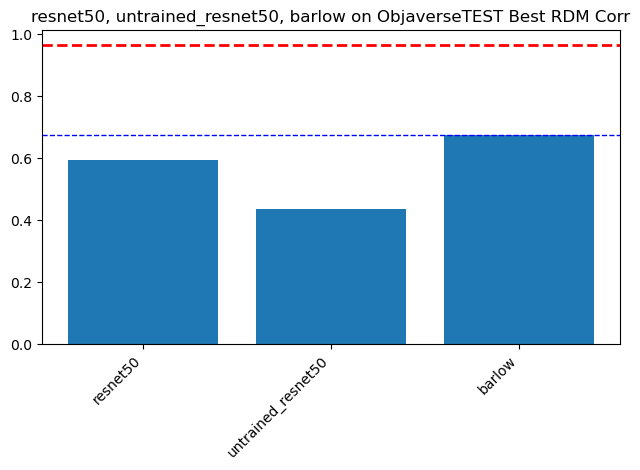

In [106]:
# Plot best fits
plot_best_fit(model_to_rdm_dict, rdm_shr, title=f'{models_title} on {monkeys_title}{imageset}{notes}')
plt.tight_layout()

plt.savefig(
    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{monkeys_title}{models_title}_on_{imageset}_Best_RDM_Corrs{notes}',
    bbox_inches='tight')

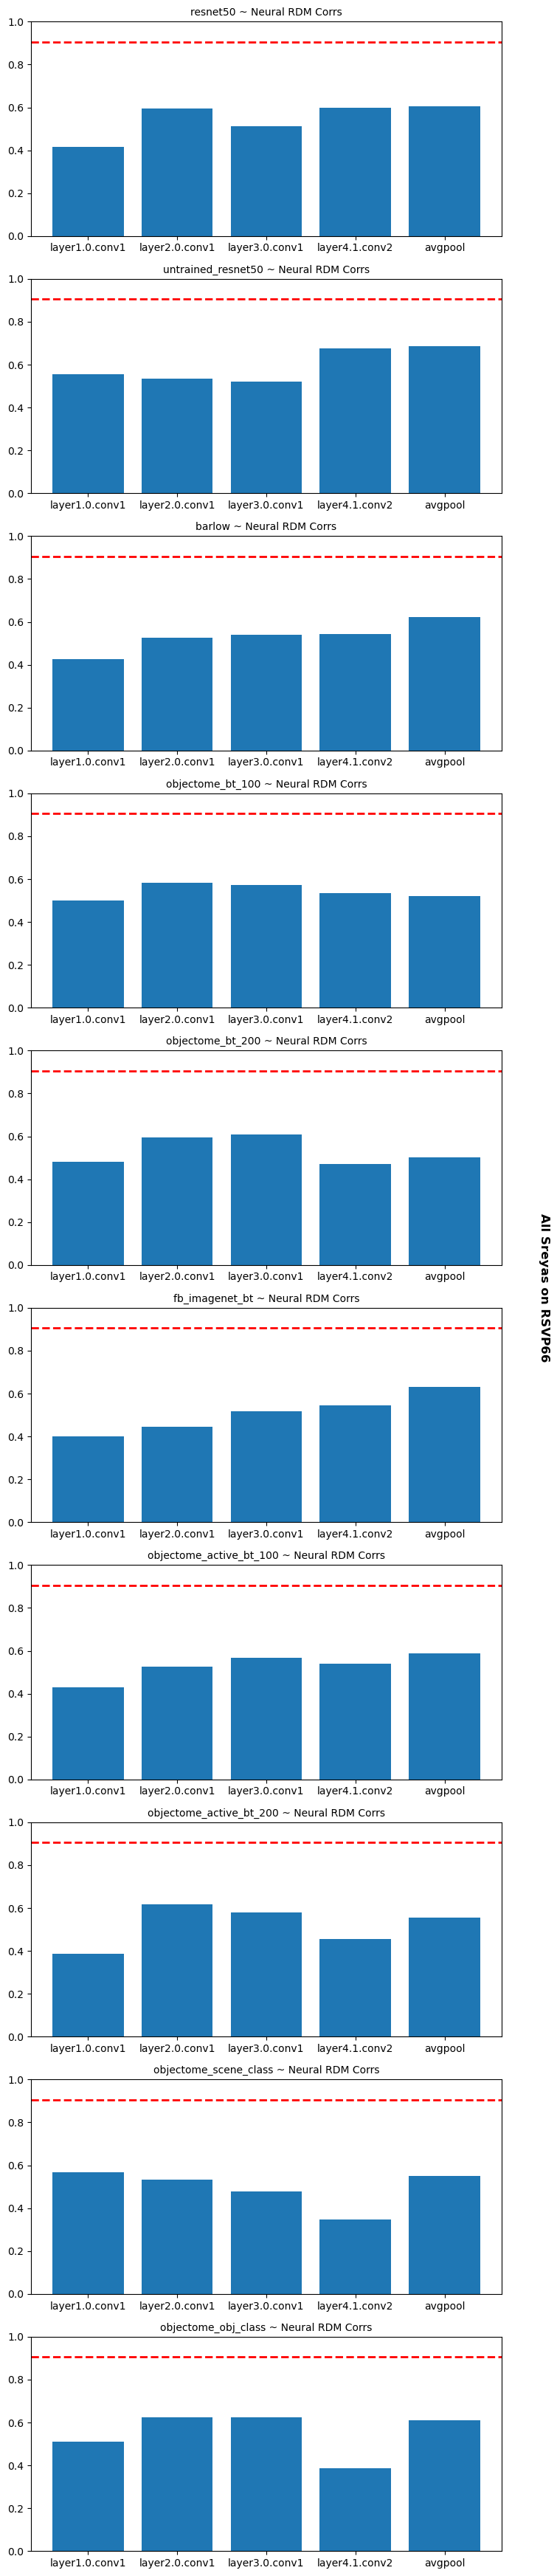

In [47]:
# Plot correlations
title = f'{models_title} on {imageset}'
plot_nested_correlations(model_to_rdm_dict, rdm_shr, title)

plt.savefig(
    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{models_title}_RDM_Corrs{notes}',
    bbox_inches='tight')

plt.show()

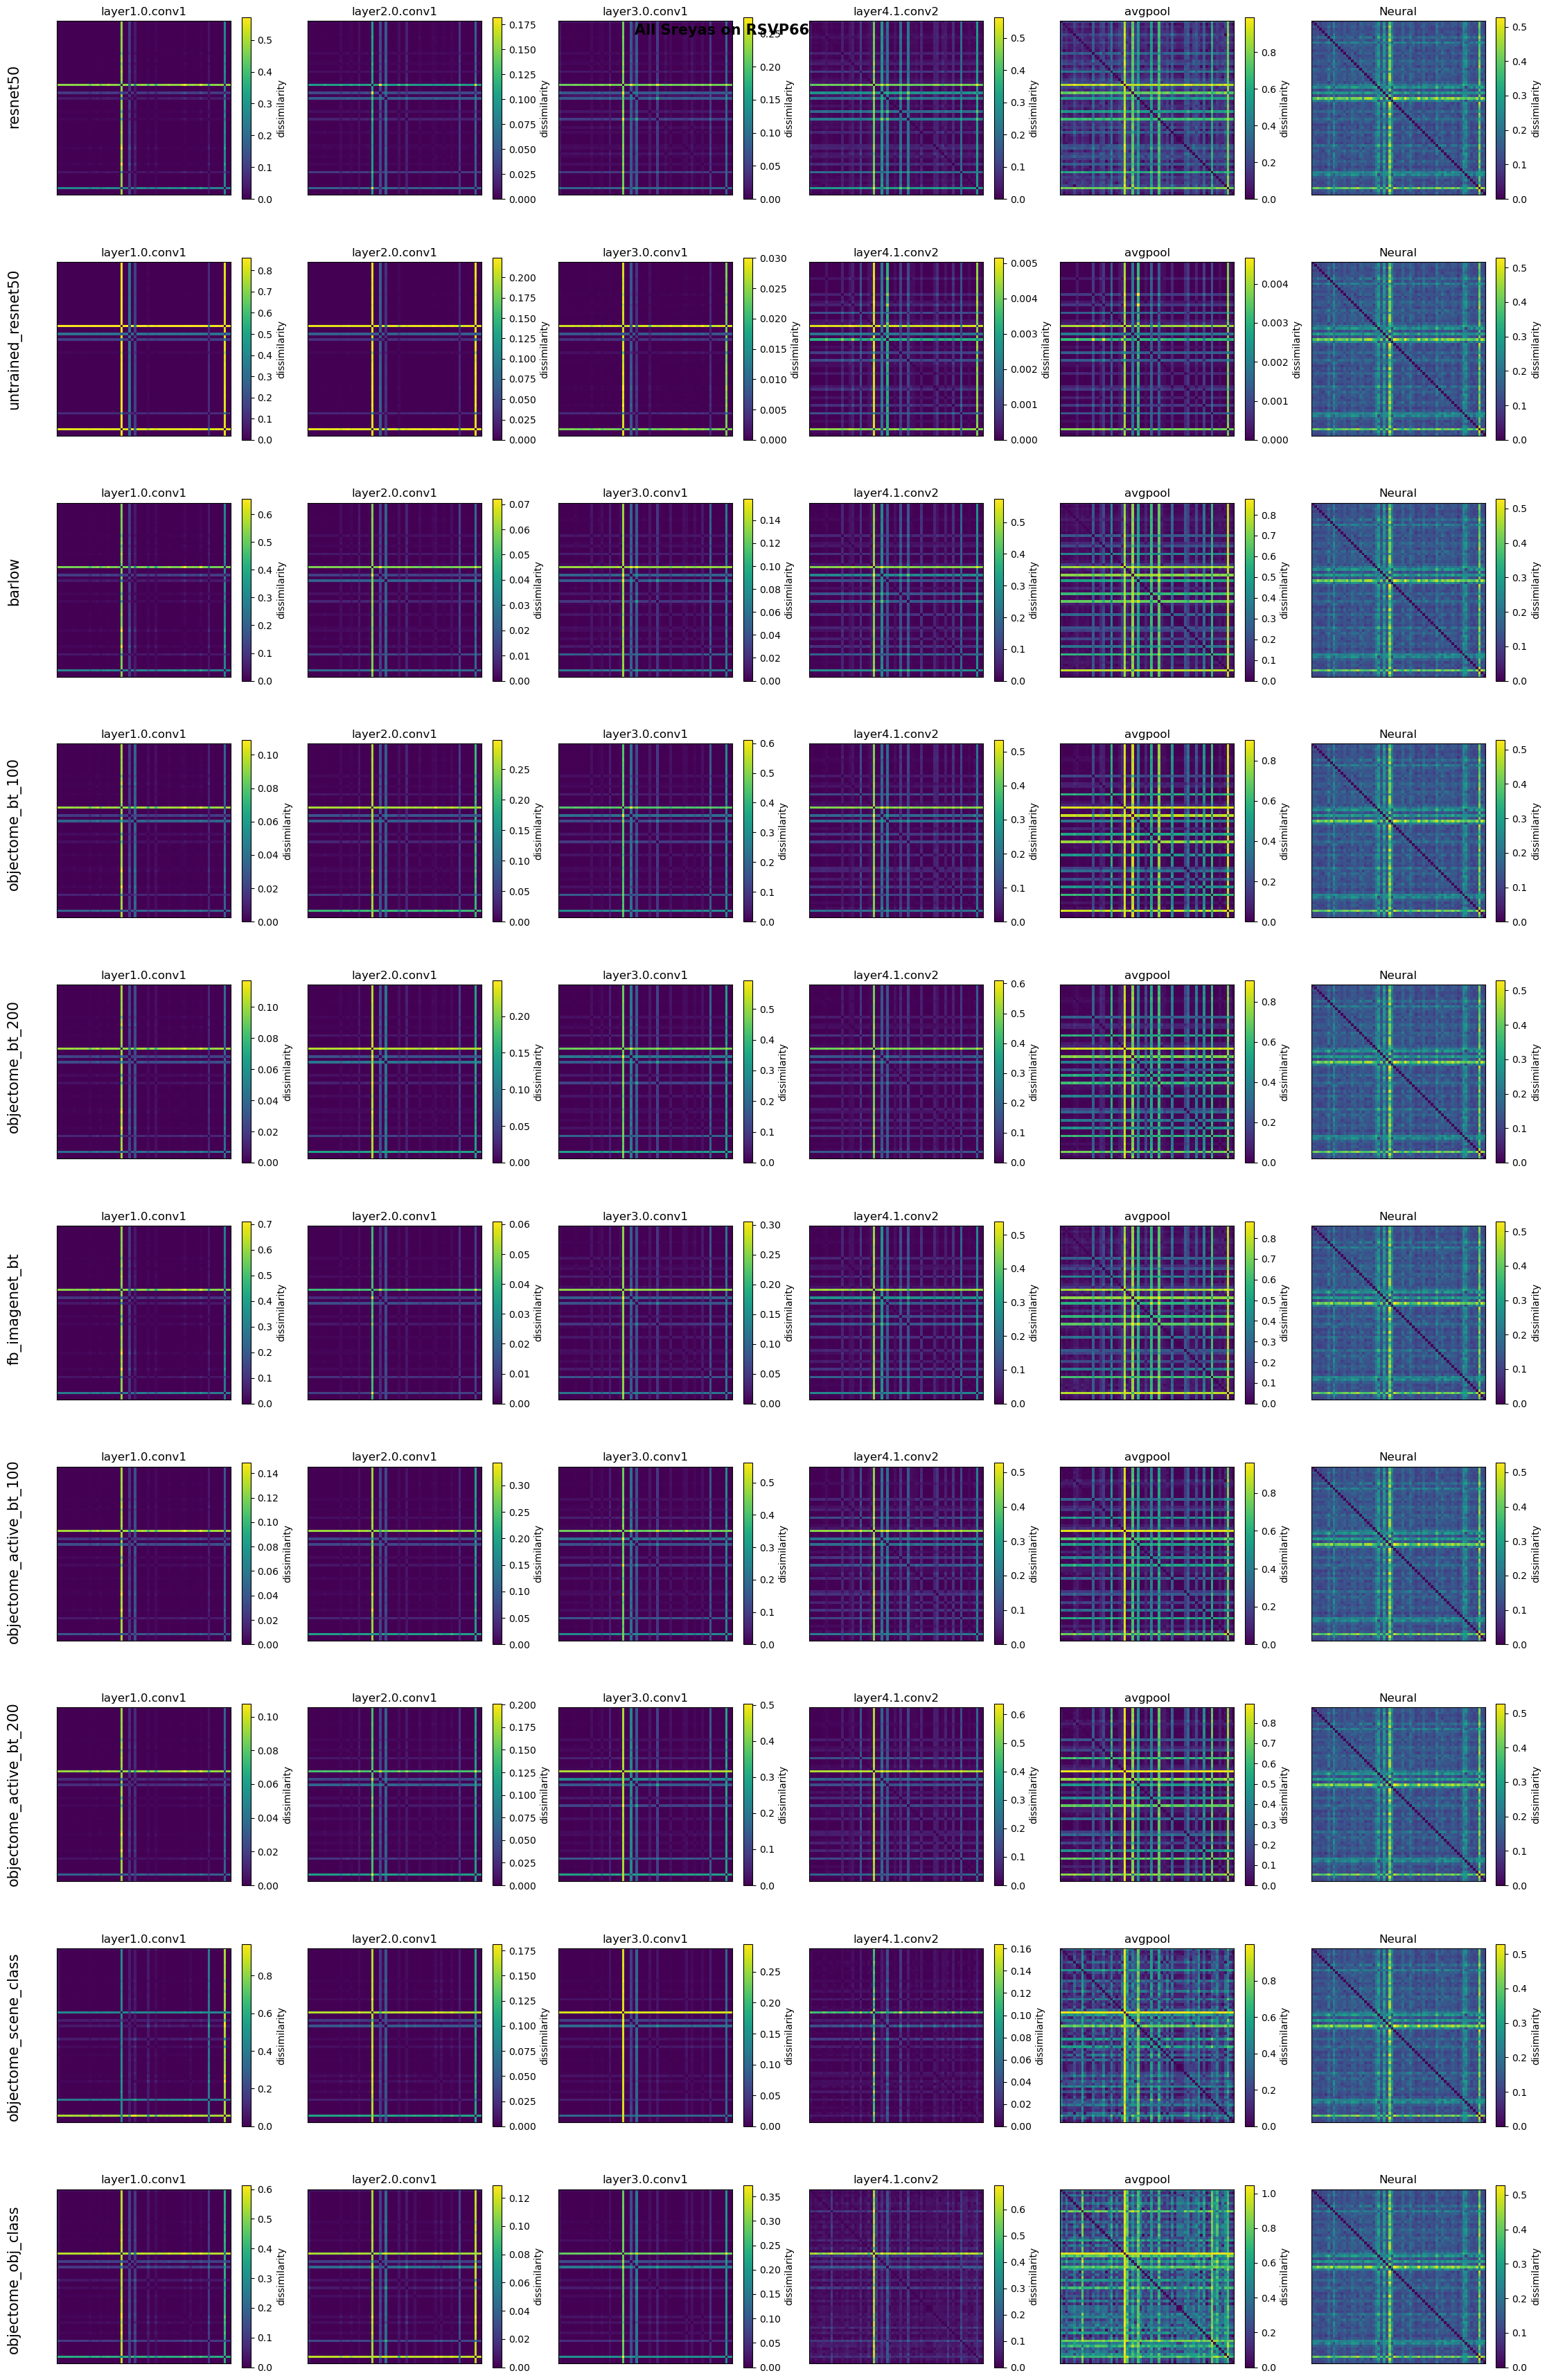

In [46]:
# Plot RDMs
plot_nested_rdm(model_to_rdm_dict)
plt.suptitle(f'{models_title} on {imageset}', fontsize=15, fontweight='bold')

plt.savefig(
    f'/mnt/smb/locker/issa-locker/users/Parsa/marmoset_figures/{imageset}/{models_title}_RDMs{notes}',
    bbox_inches='tight')

plt.show()

In [41]:
# Multi GPU processing (minimal improvement)

model_name = 'resnet50'

def parallelize_processing(img_paths, model_name, transform, layer_names, num_gpus):
    """Main function to parallelize across GPUs"""
    
    # Split paths into batches for each GPU
    batch_size = len(img_paths) // num_gpus
    batches_args = []
    
    # Split into batches and create args
    for i in range(num_gpus):
        start_idx = i * batch_size
        if i == num_gpus - 1:  # Last batch gets remaining images
            end_idx = len(img_paths)
        else:
            end_idx = (i + 1) * batch_size
        
        batch_paths = img_paths[start_idx:end_idx]
        batches_args.append((batch_paths, i, model_name, transform, layer_names))
    
    # Process batches in parallel
    with tmp.Pool(processes=num_gpus) as pool:
        batch_results = pool.map(process_batch, batches_args)
    
    # Combine results from all batches
    combined_results = pd.concat(batch_results, ignore_index=True)
    
    return combined_results

%%time
model_to_activations = {}
model_to_rdm_dict = {}

if __name__ == "__main__":
    tmp.set_start_method('spawn', force=True)
    
    # Run parallelized processing
    results = parallelize_processing(img_paths, model_name, transform, layer_names, num_gpus=gpu_count)
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    
    # Create + save rdm to rdm_dict
    responses = model_activations
    responses['Neural'] = trial_avg_series
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.vstack(responses[col].values)
    rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
    model_to_rdm_dict[model_name] = rdm_dict
    
    print(model_name)

In [82]:
# Single CPU processing

%%time
# Run models, get activations, RDM dicts

model_to_activations = {}
model_to_rdm_dict = {}

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

def get_activation(name):
    def hook(model, input, output):
        # Flatten the activation and convert to numpy
        # This handles different layer types (conv, fc, pool, etc.)
        if len(output.shape) > 2:  # Conv layers: (batch, channels, height, width)
            # Global average pooling to get (batch, channels)
            activations[name] = torch.mean(output, dim=(2, 3)).detach().cpu().numpy().flatten()
        else:  # FC layers: (batch, features)
            activations[name] = output.detach().cpu().numpy().flatten()
    return hook

for model_name in model_names:
    # Load model
    if model_name == 'untrained_resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
    elif model_name == 'resnet50':
        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
    elif model_name == 'barlow':
        model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(pretrained=True)
    elif model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True) 
    
    # Df to store all results
    model_activations = pd.DataFrame(index=img_paths, columns=layer_names)
    
    # Set up hooks for all layers
    activations = {}
    hooks = []
    
    # Register hooks
    for name, layer in model.named_modules():
        if name in layer_names:
            hook = layer.register_forward_hook(get_activation(name))
            hooks.append(hook)
    
    # Process each image
    model.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}')
    model = model.to(device)
    
    with torch.no_grad():
        for i, path in enumerate(img_paths):
            # Load and preprocess image
            img = Image.open(path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim, move to GPU
                    
            # Clear previous activations
            activations.clear()
            
            # Forward pass
            _ = model(img_tensor)
            
            # Store results
            model_activations.loc[path] = activations.copy()
            
            if i%50 == 0:
                print(f'{model_name}: {i}/{len(img_paths)}')
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    # Create DataFrame, save activations
    model_to_activations[model_name] = model_activations
    
    # Create + save rdm to rdm_dict
    responses = model_activations
    responses['Neural'] = trial_avg_series
    resp_dict = {}
    for col in responses.columns:
        resp_dict[col] = np.vstack(responses[col].values)
    rdm_dict = {label: rdm(resp) for label, resp in resp_dict.items()}
    model_to_rdm_dict[model_name] = rdm_dict # Single CPU Processing

Using cache found in /home/pt2636/.cache/torch/hub/pytorch_vision_v0.10.0


Device: cuda
resnet50: 0/305
resnet50: 50/305
resnet50: 100/305
resnet50: 150/305
resnet50: 200/305
resnet50: 250/305
resnet50: 300/305
CPU times: user 1min 15s, sys: 2.42 s, total: 1min 17s
Wall time: 36.3 s
